# Models for mixed data

* dataset has both numeric/categoric features and other, structured data (images, text, etc.)
* NN for structured data, traditional models for other
* how to combine them?
* naïve approach: NN as one model of an ensemble
* can we use a more clever approach?

## Imports and data preparation

In [ ]:
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
# reading in data
PATH = 'drive/MyDrive/DM+DL órák anyagai/AI képzés DM gyakorlatok/Competition 4 data/' # path to data (modify this accordingly)
imgs = np.load(PATH + 'imgs.npy')
df = pd.read_csv(PATH + 'train.csv')

# separating target variable and image indices
y = (df['Prognosis'] == 'SEVERE').astype(int)
imgs_idcs = df['Image']
df.drop(['Row_number', 'Death', 'Prognosis'], axis = 1, inplace = True)

# one-hot encoding for hospitals
df = pd.get_dummies(df, columns = ['Hospital'], prefix = 'Hospital')

# preprocessing
df.fillna(value = df.mean(), inplace = True) # imputing with mean
df = df / df.abs().max() # max abs scaling

# performing train/val split
y_train, y_val = y[:800], y[800:]
train_idcs, val_idcs = imgs_idcs[:800], imgs_idcs[800:]
x_train, x_val = df.iloc[:800], df.iloc[800:] 

In [ ]:
import torch

# custom dataset object
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, tabular, target, img_idcs, transforms = None, img_channel_number = 3):
        self.tabular = tabular
        self.target = target
        self.img_idcs = img_idcs
        self.transforms = transforms
        self.num_channels = img_channel_number
    
    def __getitem__(self, idx):
        tabular = torch.FloatTensor(self.tabular.iloc[idx]) # convert tabular data to tensor
        target = torch.FloatTensor([self.target.iloc[idx]])

        img_idx = self.img_idcs.iloc[idx] # get index of corresponding image
        img = torch.FloatTensor(imgs[img_idx])
        img = torch.stack([img for _ in range(self.num_channels)]) # convert image to greyscale with given channel numbers
        if self.transforms: # optional transforms
            img = self.transforms(img)
        return {'img': img, 'target': target, 'tabular': tabular}

    def __len__(self):
        return len(self.target)

In [ ]:
import torchvision

# define train and val ds
train_trsfs = torchvision.transforms.Compose([
                                              torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.25, 0.25, 0.25]),
                                              torchvision.transforms.RandomRotation(degrees = 15)
])
val_trsfs = torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.25, 0.25, 0.25])

train_ds = CustomDataset(x_train, y_train, train_idcs, transforms = train_trsfs)
val_ds = CustomDataset(x_val, y_val, val_idcs, transforms = val_trsfs)

# batching
train_data = torch.utils.data.DataLoader(train_ds, shuffle = True, batch_size = 32)
val_data = torch.utils.data.DataLoader(val_ds, batch_size = 32)

## NN as feature extractor 

*  we train a NN on the images, but instead of using its output, we use its hidden representation as additional features for a traditional ML model

In [ ]:
# training loop
def train(model, loss_fn, optim, num_epochs = 5):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    train_accs, val_accs = [], []
    model.to(device)
    for _ in range(num_epochs):
        model.train()
        accs = []
        for batch in train_data:
            optim.zero_grad()
            pred = model(batch['img'].to(device))
            y = batch['target'].to(device)
            accs.append(torch.sum((pred > 0.5) == y).item())
            loss = loss_fn(pred, y)
            loss.backward()
            optim.step()
        train_accs.append(np.sum(accs) / len(train_ds))

        model.eval()
        accs = []
        with torch.no_grad():
            for batch in val_data:
                pred = model(batch['img'].to(device))
                accs.append(torch.sum((pred > 0.5) == batch['target'].to(device)).item())
        val_accs.append(np.sum(accs) / len(val_ds))
    model.to('cpu')
    return train_accs, val_accs

In [ ]:
conv_model = torchvision.models.resnet18(pretrained = True) # load model
conv_model.fc = torch.nn.Sequential( # replace last layer
        torch.nn.Linear(in_features = 512, out_features = 32),
        torch.nn.Linear(in_features = 32, out_features = 1),
        torch.nn.Sigmoid())

loss = torch.nn.BCELoss()
optim = torch.optim.Adam(conv_model.parameters(), lr = 1e-5, weight_decay = 1e-4)

In [ ]:
train_accs, val_accs = train(conv_model, loss, optim)

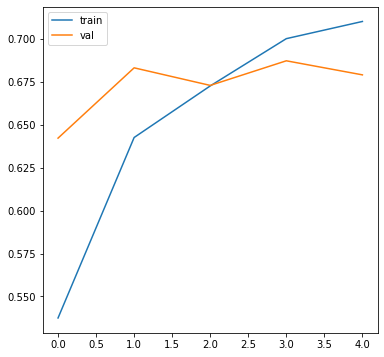

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize = (6, 6))
plt.plot(train_accs, label = 'train')
plt.plot(val_accs, label = 'val')
plt.legend()
plt.show()

In [ ]:
print('Final accuracy on validation set: {:.2f}%'.format(100 * val_accs[-1]))

Final accuracy on validation set: 67.89%


In [ ]:
# get inner representation (output of the first dense layer)
def get_inner_repr(model, x):
    repr = None
    def _hook(module_, input_, output_):
        nonlocal repr
        repr = output_
    hook = model.fc[0].register_forward_hook(_hook)
    model(x)
    hook.remove()
    return repr.to('cpu')

In [ ]:
preds = []
conv_model.to('cuda')
conv_model.eval()
with torch.no_grad():
    for i in range(len(df)):
        torch.cuda.empty_cache()
        img = imgs[imgs_idcs.iloc[i]]
        img = torch.FloatTensor(img)
        img = torch.stack([img for _ in range(3)])    
        img = val_trsfs(img)
        batched_img = img.reshape((1, *img.shape)).to('cuda')
        preds.append(get_inner_repr(conv_model, batched_img))
conv_model = conv_model.to('cpu')

In [ ]:
# add image represenations to dataset
df[[f'feature{i+1}' for i in range(32)]] = np.array([np.array(pred.flatten()) for pred in preds])

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score

svm = SVC(kernel = 'rbf')
svm.fit(x_train, y_train)
print('Baseline performance: {:.2f}%'.format(100 * balanced_accuracy_score(svm.predict(x_val), y_val)))

# get performance with added features
x_train_2, x_val_2 = df.iloc[:800], df.iloc[800:]
svm.fit(x_train_2, y_train)
print('Performance with added features: {:.2f}%'.format(100* balanced_accuracy_score(svm.predict(x_val_2), y_val)))

Baseline performance: 66.36%
Performance with added features: 70.07%


## NN model trained on all kinds of data

* we train one NN model on all data
* it should learn an image representation best suited to augment the tabular data
* might require more precise hyperparameter optimisation
* might be harder to train

In [ ]:
# build NN model to predict from both image and tabular data
class MixedModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        conv_model = torchvision.models.resnet18(pretrained = True)
        conv_model.fc = torch.nn.Linear(in_features = 512, out_features = 32)
        self.conv_model = conv_model

        self.tabular_model = torch.nn.Linear(in_features = 42, out_features = 32)
        self.dropout = torch.nn.Dropout(p = 0.4)
        self.final_layer = torch.nn.Linear(in_features = 64, out_features = 1)
    
    def forward(self, img, tabular):
        x1 = self.conv_model(img)
        x1 = torch.nn.functional.relu(x1)

        x2 = self.tabular_model(tabular)
        x2 = torch.nn.functional.leaky_relu(x2, negative_slope = 0.2)
        x = torch.cat([x1, x2], axis = 1)
        x = self.dropout(x)
        x = self.final_layer(x)
        return torch.sigmoid(x)

In [ ]:
# training loop
def train_with_tabular(model, loss_fn, optim, num_epochs = 5):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    train_accs, val_accs = [], []
    model.to(device)
    for _ in range(num_epochs):
        model.train()
        accs = []
        for batch in train_data:
            optim.zero_grad()
            img, tabular = batch['img'].to(device), batch['tabular'].to(device)
            pred = model(img, tabular)
            y = batch['target'].to(device)
            accs.append(torch.sum((pred > 0.5) == y).item())
            loss = loss_fn(pred, y)
            loss.backward()
            optim.step()
        train_accs.append(np.sum(accs) / len(train_ds))

        model.eval()
        accs = []
        with torch.no_grad():
            for batch in val_data:
                img, tabular = batch['img'].to(device), batch['tabular'].to(device)
                pred = model(img, tabular)
                accs.append(torch.sum((pred > 0.5) == batch['target'].to(device)).item())
        val_accs.append(np.sum(accs) / len(val_ds))
    model.to('cpu')
    return train_accs, val_accs

In [ ]:
mixed_model = MixedModel()

loss = torch.nn.BCELoss()
optim = torch.optim.Adam(mixed_model.parameters(), lr = 1e-5, weight_decay = 1e-4)

In [ ]:
train_accs, val_accs = train_with_tabular(mixed_model, loss, optim, num_epochs = 10)

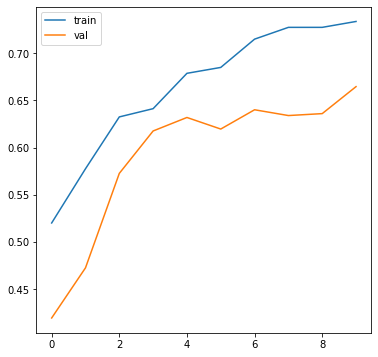

In [ ]:
plt.figure(figsize = (6, 6))
plt.plot(train_accs, label = 'train')
plt.plot(val_accs, label = 'val')
plt.legend()
plt.show()

In [ ]:
print('Final accuracy on validation set: {:.2f}%'.format(100 * val_accs[-1]))

Final accuracy on validation set: 66.46%
